[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/044_cnn_transfer_learning/cnn_transfer_learning.ipynb)

# Transfer Learning en Redes Convolucionales

En posts anteriores hemos introducido la arquitectura de `red neuronal convolucional` y también hemos presentado varias arquitecturas famosas que han demostrado buenas prestaciones en multitud de tareas. Estas redes están formadas muchas capas convolucionales, algunas con más de 100 capas, lo cual significa que tienen muchos parámetros y entrenarlas desde cero puedes ser costoso. Sin embargo, existe una técnica que nos permite obtener buenos modelos con menores requisitos: el *transfer learning*. Ya hemos hablado anteriormente de esta técnica, en el contexto de modelos de lenguaje, pero la idea es la misma: utilizaremos el máximo número de capas de una red ya entrenada en otro dataset, y simplemente entrenaremos las nuevas capas que necesitemos para nuestra tarea concreta.

![](https://pennylane.ai/qml/_images/transfer_learning_general.png)

En este post vamos a ver cómo podemos utilizar una red neuronal pre-entrada en Imagenet, y adaptarla para una nueva tarea de clasificación con un pequeño dataset.

## El dataset

Nuestro objetivo será el de entrenar un clasificador de flores. Podemos descargar las imágenes de la siguiente url.

In [1]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=390d54b2aa6543c0a01c16e0fc67af1bdb1c32d41303ab9c69e7d4ebfe09ac13
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import wget

# wget.download('https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/flowers.zip')

In [4]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/InteligenciaArtificial ll/datasets/data.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

Una vez extraído el dataset, podemos ver que tenemos 5 clases de flores diferentes, distribuidas en 5 carpetas diferentes. Cada carpeta contiene varios ejemplos de flores de la categoría en cuestión.

In [5]:
import os

PATH = 'data'

classes = os.listdir(PATH)
classes

['Rook', 'Bishop', 'Knight', 'Pawn', 'King', 'Queen']

In [6]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: Rook. Imágenes: 85
Categoría: Bishop. Imágenes: 74
Categoría: Knight. Imágenes: 93
Categoría: Pawn. Imágenes: 95
Categoría: King. Imágenes: 71
Categoría: Queen. Imágenes: 65


In [7]:
imgs[:6]
len(imgs)

410

Podemos visualizar algunas imágenes en el dataset.

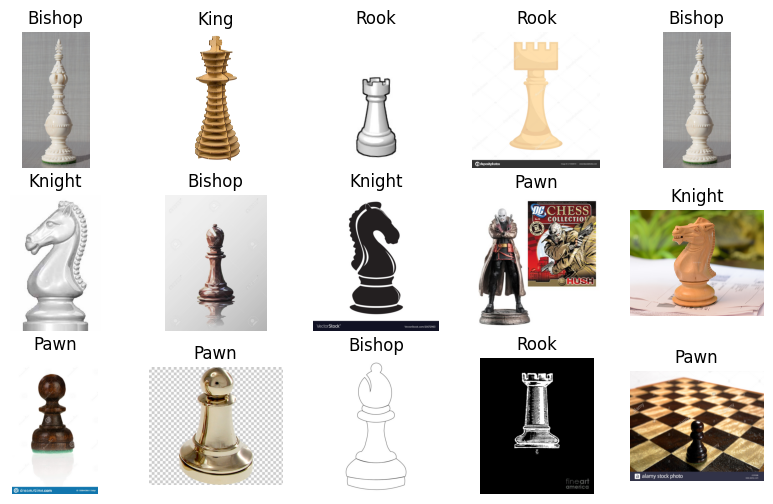

In [8]:
import random
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

Vamos a crear también un subconjunto de test para poder comparar varios modelos.

In [9]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(328, 82)

Y por último creamos nuestros objetos `Dataset` y `DataLoader` para poder darle las imágenes a nuestros modelos.

In [10]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    #print(f"imagen: {img}")
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

cuda


Nos aseguraremos que todas las imágenes del dataset tengan las mismas dimensiones: 224x224 píxeles.

In [11]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device),
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(328, 82)

In [12]:
dataset['train'][2]

(tensor([[[0.9490, 0.9490, 0.9490,  ..., 0.8980, 0.8980, 0.8980],
          [0.9490, 0.9490, 0.9490,  ..., 0.8980, 0.8980, 0.8980],
          [0.9490, 0.9490, 0.9490,  ..., 0.8980, 0.8980, 0.8980],
          ...,
          [0.1961, 0.1961, 0.1961,  ..., 0.1961, 0.1961, 0.1961],
          [0.1961, 0.1961, 0.1961,  ..., 0.1961, 0.1961, 0.1961],
          [0.1961, 0.1961, 0.1961,  ..., 0.1961, 0.1961, 0.1961]],
 
         [[0.9490, 0.9490, 0.9490,  ..., 0.8980, 0.8980, 0.8980],
          [0.9490, 0.9490, 0.9490,  ..., 0.8980, 0.8980, 0.8980],
          [0.9490, 0.9490, 0.9490,  ..., 0.8980, 0.8980, 0.8980],
          ...,
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000]],
 
         [[0.9490, 0.9490, 0.9490,  ..., 0.8980, 0.8980, 0.8980],
          [0.9490, 0.9490, 0.9490,  ..., 0.8980, 0.8980, 0.8980],
          [0.9490, 0.9490, 0.9490,  ...,

In [29]:
imagen, etiqueta = dataset['train'][2]

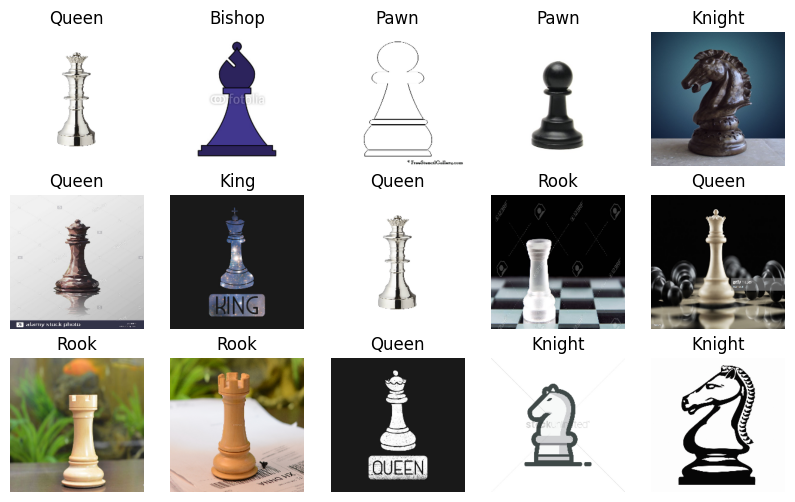

In [13]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [14]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=64, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 224, 224])

## El Modelo

Vamos a escoger la arquitectura `resnet`, de la que ya hablamos en el post anterior, para hacer nuestro clasificador. De este modelo usarmos todas las capas excepto la última, la cual sustituiremos por una nueva capa lineal para llevar a cabo la clasificación en 5 clases.

In [15]:
import torchvision

resnet = torchvision.models.resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
class ModelCustom(torch.nn.Module):
  def __init__(self, n_outputs=6, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, 6)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

In [17]:
model_custom = ModelCustom()
outputs = model_custom(torch.randn(64, 3, 224, 224))
outputs.shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([64, 6])

In [18]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=10, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

### Entrenando desde cero

En primer lugar vamos a entrenar nuestro modelo desde cero para ver qué métricas podemos obtener.

In [19]:
model_c = ModelCustom()
fit(model_c, dataloader, epochs=15)

val_loss 1.78275 val_acc 0.18490: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Epoch 1/15 loss 1.78983 val_loss 1.78275 acc 0.19010 val_acc 0.18490


val_loss 1.74964 val_acc 0.20486: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Epoch 2/15 loss 1.77546 val_loss 1.74964 acc 0.22396 val_acc 0.20486


val_loss 1.79991 val_acc 0.18490: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


Epoch 3/15 loss 1.76172 val_loss 1.79991 acc 0.22135 val_acc 0.18490


val_loss 1.81114 val_acc 0.13368: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Epoch 4/15 loss 1.76201 val_loss 1.81114 acc 0.18750 val_acc 0.13368


val_loss 1.82052 val_acc 0.23698: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Epoch 5/15 loss 1.73265 val_loss 1.82052 acc 0.24740 val_acc 0.23698


val_loss 1.86672 val_acc 0.10156: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Epoch 6/15 loss 1.78652 val_loss 1.86672 acc 0.19531 val_acc 0.10156


val_loss 1.85208 val_acc 0.13715: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Epoch 7/15 loss 1.76105 val_loss 1.85208 acc 0.22917 val_acc 0.13715


val_loss 1.88267 val_acc 0.20486: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


Epoch 8/15 loss 1.74774 val_loss 1.88267 acc 0.27344 val_acc 0.20486


val_loss 1.90203 val_acc 0.24826: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Epoch 9/15 loss 1.72892 val_loss 1.90203 acc 0.23177 val_acc 0.24826


val_loss 1.87292 val_acc 0.22049: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


Epoch 10/15 loss 1.70779 val_loss 1.87292 acc 0.25260 val_acc 0.22049


val_loss 1.98983 val_acc 0.21267: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch 11/15 loss 1.69970 val_loss 1.98983 acc 0.26562 val_acc 0.21267


val_loss 2.21849 val_acc 0.20486: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Epoch 12/15 loss 1.69681 val_loss 2.21849 acc 0.25260 val_acc 0.20486


val_loss 2.21025 val_acc 0.22049: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Epoch 13/15 loss 1.67582 val_loss 2.21025 acc 0.29167 val_acc 0.22049


val_loss 3.81108 val_acc 0.18490: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Epoch 14/15 loss 1.67567 val_loss 3.81108 acc 0.26042 val_acc 0.18490


val_loss 1.94730 val_acc 0.18490: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

Epoch 15/15 loss 1.74375 val_loss 1.94730 acc 0.23958 val_acc 0.18490


Como puedes ver es complicado conseguir buenas métricas ya que nuestro dataset es muy pequeño.

## Transfer Learning

Ahora vamos a entrenar el mismo caso pero, en este caso, utilizando los pesos pre-entrenados de `resnet`.

In [20]:
model_c = ModelCustom(pretrained=True, freeze=True)
fit(model_c, dataloader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 305MB/s]
val_loss 1.83003 val_acc 0.19705: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Epoch 1/10 loss 1.89984 val_loss 1.83003 acc 0.16406 val_acc 0.19705


val_loss 2.02436 val_acc 0.18490: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Epoch 2/10 loss 1.76425 val_loss 2.02436 acc 0.24219 val_acc 0.18490


val_loss 1.72540 val_acc 0.25174: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


Epoch 3/10 loss 1.64746 val_loss 1.72540 acc 0.37240 val_acc 0.25174


val_loss 1.56380 val_acc 0.42622: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


Epoch 4/10 loss 1.55327 val_loss 1.56380 acc 0.37500 val_acc 0.42622


val_loss 1.62058 val_acc 0.39323: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Epoch 5/10 loss 1.41011 val_loss 1.62058 acc 0.52604 val_acc 0.39323


val_loss 1.46881 val_acc 0.42969: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Epoch 6/10 loss 1.39018 val_loss 1.46881 acc 0.49479 val_acc 0.42969


val_loss 1.61298 val_acc 0.31858: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Epoch 7/10 loss 1.39123 val_loss 1.61298 acc 0.53125 val_acc 0.31858


val_loss 1.44787 val_acc 0.42622: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Epoch 8/10 loss 1.28025 val_loss 1.44787 acc 0.59635 val_acc 0.42622


val_loss 1.50435 val_acc 0.40538: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Epoch 9/10 loss 1.26977 val_loss 1.50435 acc 0.59635 val_acc 0.40538


val_loss 1.42634 val_acc 0.55642: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

Epoch 10/10 loss 1.22585 val_loss 1.42634 acc 0.64583 val_acc 0.55642


Como puedes ver no sólo obtenemos un mejor modelo en menos *epochs* sino que además cada *epoch* tarda menos en completarse. Esto es debido a que, al no estar entrenando gran parte de la red, los requisitos computacionales se reducen considerablemente. Mejores modelos y entrenados más rápido.

## Fine Tuning

Todavía podemos mejorar un poco más si, además de utilizar los pesos descargados de Imagenet en `resnet`, entrenamos también la red completa.

In [21]:
model_c = ModelCustom(pretrained=True, freeze=False)
fit(model_c, dataloader)

val_loss 1.81376 val_acc 0.30729: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Epoch 1/10 loss 1.74733 val_loss 1.81376 acc 0.25781 val_acc 0.30729


val_loss 1.44566 val_acc 0.43316: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Epoch 2/10 loss 1.50617 val_loss 1.44566 acc 0.46354 val_acc 0.43316


val_loss 1.35257 val_acc 0.43316: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


Epoch 3/10 loss 1.15206 val_loss 1.35257 acc 0.70312 val_acc 0.43316


val_loss 1.21880 val_acc 0.55990: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Epoch 4/10 loss 1.07705 val_loss 1.21880 acc 0.66667 val_acc 0.55990


val_loss 1.17271 val_acc 0.50000: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Epoch 5/10 loss 0.90923 val_loss 1.17271 acc 0.77083 val_acc 0.50000


val_loss 1.00017 val_acc 0.63802: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Epoch 6/10 loss 0.74701 val_loss 1.00017 acc 0.83073 val_acc 0.63802


val_loss 0.99370 val_acc 0.62587: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch 7/10 loss 0.67292 val_loss 0.99370 acc 0.86458 val_acc 0.62587


val_loss 0.91165 val_acc 0.65451: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Epoch 8/10 loss 0.61297 val_loss 0.91165 acc 0.86198 val_acc 0.65451


val_loss 0.86554 val_acc 0.64149: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Epoch 9/10 loss 0.45420 val_loss 0.86554 acc 0.92188 val_acc 0.64149


val_loss 0.70269 val_acc 0.74479: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

Epoch 10/10 loss 0.37306 val_loss 0.70269 acc 0.94010 val_acc 0.74479


Es común entrenar primero el modelo sin entrenar la red pre-entrenada durante varias epochs y después seguir entrenando, pero permitiendo ahora la actualización de pesos también en la red pre-entrenada (usualmente con un *learning rate* más pequeño).

In [22]:
model_o = ModelCustom(pretrained=True, freeze=True)
fit(model_o, dataloader)
model_o.unfreeze()
fit(model_o, dataloader, lr=1e-4)

val_loss 1.71878 val_acc 0.29167: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Epoch 1/10 loss 1.84178 val_loss 1.71878 acc 0.19271 val_acc 0.29167


val_loss 2.00439 val_acc 0.18490: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Epoch 2/10 loss 1.82072 val_loss 2.00439 acc 0.25260 val_acc 0.18490


val_loss 1.72053 val_acc 0.37066: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Epoch 3/10 loss 1.66921 val_loss 1.72053 acc 0.36979 val_acc 0.37066


val_loss 1.51936 val_acc 0.34201: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


Epoch 4/10 loss 1.63636 val_loss 1.51936 acc 0.37760 val_acc 0.34201


val_loss 1.48734 val_acc 0.48438: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Epoch 5/10 loss 1.46786 val_loss 1.48734 acc 0.46094 val_acc 0.48438


val_loss 1.43642 val_acc 0.45312: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Epoch 6/10 loss 1.34357 val_loss 1.43642 acc 0.60677 val_acc 0.45312


val_loss 1.44633 val_acc 0.45312: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Epoch 7/10 loss 1.34155 val_loss 1.44633 acc 0.53906 val_acc 0.45312


val_loss 1.41095 val_acc 0.41406: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Epoch 8/10 loss 1.36470 val_loss 1.41095 acc 0.54948 val_acc 0.41406


val_loss 1.36915 val_acc 0.48090: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Epoch 9/10 loss 1.25957 val_loss 1.36915 acc 0.61719 val_acc 0.48090


val_loss 1.51602 val_acc 0.27951: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Epoch 10/10 loss 1.21426 val_loss 1.51602 acc 0.61979 val_acc 0.27951


val_loss 1.50297 val_acc 0.29514: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Epoch 1/10 loss 1.36755 val_loss 1.50297 acc 0.44271 val_acc 0.29514


val_loss 1.49158 val_acc 0.29514: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Epoch 2/10 loss 1.28451 val_loss 1.49158 acc 0.47656 val_acc 0.29514


val_loss 1.48167 val_acc 0.30295: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Epoch 3/10 loss 1.34972 val_loss 1.48167 acc 0.44271 val_acc 0.30295


val_loss 1.44944 val_acc 0.39410: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


Epoch 4/10 loss 1.29734 val_loss 1.44944 acc 0.47135 val_acc 0.39410


val_loss 1.42847 val_acc 0.40191: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Epoch 5/10 loss 1.25935 val_loss 1.42847 acc 0.46615 val_acc 0.40191


val_loss 1.41628 val_acc 0.39410: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Epoch 6/10 loss 1.24074 val_loss 1.41628 acc 0.53385 val_acc 0.39410


val_loss 1.40569 val_acc 0.43750: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Epoch 7/10 loss 1.20871 val_loss 1.40569 acc 0.54167 val_acc 0.43750


val_loss 1.37582 val_acc 0.46094: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Epoch 8/10 loss 1.25234 val_loss 1.37582 acc 0.52344 val_acc 0.46094


val_loss 1.37474 val_acc 0.48872: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Epoch 9/10 loss 1.18838 val_loss 1.37474 acc 0.56510 val_acc 0.48872


val_loss 1.37271 val_acc 0.48090: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

Epoch 10/10 loss 1.23571 val_loss 1.37271 acc 0.59375 val_acc 0.48090


Otra alternativa de *fine tuning* es la de entrenar el modelo con diferentes *learning rates*, uno para la red pre-entrenada y otro para las capas nuevas.

In [23]:
optimizer = torch.optim.Adam([
    {'params': model_o.resnet.parameters(), 'lr': 1e-4},
    {'params': model_o.fc.parameters(), 'lr': 1e-3}
])

In [24]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr_resnet=1e-4, lr_fc=1e-3):
    model.to(device)
    optimizer = optimizer = torch.optim.Adam([{'params': model.resnet.parameters(), 'lr': lr_resnet},{'params': model.fc.parameters(), 'lr': lr_fc}])
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [25]:
model_o = ModelCustom(pretrained=True, freeze=True)
fit(model_o, dataloader, lr_resnet=1e-4, lr_fc=1e-3)
model_o.unfreeze()
fit(model_o, dataloader, lr_resnet=1e-4, lr_fc=1e-3)

val_loss 1.67640 val_acc 0.32378: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Epoch 1/5 loss 1.87444 val_loss 1.67640 acc 0.22135 val_acc 0.32378


val_loss 1.61916 val_acc 0.38628: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Epoch 2/5 loss 1.72481 val_loss 1.61916 acc 0.23438 val_acc 0.38628


val_loss 1.51318 val_acc 0.48872: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Epoch 3/5 loss 1.58545 val_loss 1.51318 acc 0.31510 val_acc 0.48872


val_loss 1.44511 val_acc 0.47656: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


Epoch 4/5 loss 1.50473 val_loss 1.44511 acc 0.41667 val_acc 0.47656


val_loss 1.40916 val_acc 0.47656: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Epoch 5/5 loss 1.38236 val_loss 1.40916 acc 0.54688 val_acc 0.47656


val_loss 0.80524 val_acc 0.70920: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


Epoch 1/5 loss 1.18864 val_loss 0.80524 acc 0.59115 val_acc 0.70920


val_loss 0.52988 val_acc 0.85503: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Epoch 2/5 loss 0.41292 val_loss 0.52988 acc 0.92448 val_acc 0.85503


val_loss 0.47655 val_acc 0.81944: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Epoch 3/5 loss 0.17969 val_loss 0.47655 acc 0.99479 val_acc 0.81944


val_loss 0.42307 val_acc 0.84288: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Epoch 4/5 loss 0.09255 val_loss 0.42307 acc 0.99740 val_acc 0.84288


val_loss 0.40661 val_acc 0.87066: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

Epoch 5/5 loss 0.07315 val_loss 0.40661 acc 0.97917 val_acc 0.87066


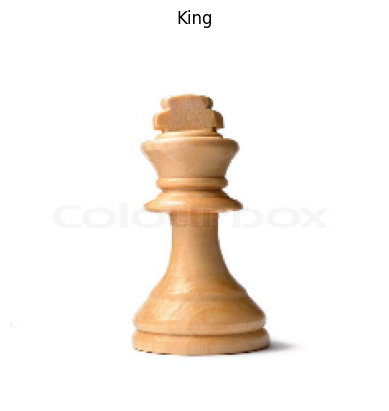

In [59]:
ix = random.randint(0, len(dataset['test'])-1)
img, lab = dataset['train'][ix]

plt.imshow(img.permute(1,2,0))
plt.axis('off')
plt.title(classes[lab])
plt.show()

In [60]:

test_image = img

test_image = test_image.to(device)
test_image = test_image.unsqueeze(0)
model_o.to(device)
model_o.eval()
with torch.no_grad():
    output = model_o(test_image)
predicted_class = torch.argmax(output, dim=1).item()
predicted_label = classes[predicted_class]

print(f"Predicción: {predicted_label}")

Predicción: King


## Resumen

En este post hemos visto como podemos llevar a cabo *transfer learning* con redes convolucionales. Aplicar esta técnica nos permitirá obtener mejores modelos con menos requisitos computacionales y con datasets reducidos. Podemos descargar una red pre-entrenada con otro dataset (idealmente, un dataset similar al nuestro) y aprovechar el máximo número de capas. Podemos *congelar* la red pre-entrenada, de manera que no se actualicen sus pesos durante el entrenamiento, y utilizarla solo como extractor de características que las nuevas capas (las cuales si entrenamos) pueden aprovechar. Aún así, hacer *fine tuning* (seguir entrenando la red pre-entrenada) puede dar como resultado un mejor modelo. El *transfer learning* es una técnica muy potente que siempre que podamos podemos aprovechar para reducir los requisitos computacionales de nuestros modelos.